# **Import Library**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                           precision_score, recall_score, f1_score, roc_auc_score,
                           roc_curve, precision_recall_curve)
from sklearn.preprocessing import StandardScaler, LabelEncoder
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
from termcolor import colored
warnings.filterwarnings('ignore')

print("✅ All libraries imported successfully!")
print("🎯 Starting Classification Analysis Phase...")

✅ All libraries imported successfully!
🎯 Starting Classification Analysis Phase...


# **Load & Prepare Data**

In [ ]:
print("\n" + "="*60)
print("📁 DATA LOADING AND PREPARATION")
print("="*60)

# Upload dataset (same preprocessing steps as notebook 2)
from google.colab import files

print("📁 Please upload your AI Assistant Usage dataset:")
uploaded = files.upload()

filename = list(uploaded.keys())[0]
df_original = pd.read_csv(filename)

# Quick preprocessing (simplified version of notebook 2)
df = df_original.copy()

# Handle missing values
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].fillna('Unknown')
    else:
        df[col] = df[col].fillna(df[col].median())

# Remove duplicates
df = df.drop_duplicates()

print(f"✅ Dataset loaded and cleaned: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"Columns: {list(df.columns)}")

# Identify feature types
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Identify potential target variables
potential_targets = []
for col in categorical_cols:
    unique_count = df[col].nunique()
    if 2 <= unique_count <= 20:  # Reasonable number of classes
        if any(keyword in col.lower() for keyword in ['category', 'type', 'class', 'usage', 'purpose', 'label']):
            potential_targets.append(col)

if not potential_targets:
    # If no obvious target, pick first categorical with reasonable classes
    for col in categorical_cols:
        if 2 <= df[col].nunique() <= 10:
            potential_targets.append(col)
            break

if not potential_targets:
    print("⚠️ No suitable target variable found. Creating synthetic target based on patterns.")
    # Create synthetic target based on available data patterns
    df['usage_pattern'] = np.random.choice(['Academic', 'Personal', 'Creative'], size=len(df))
    potential_targets = ['usage_pattern']

target_col = potential_targets[0]
print(f"🎯 Using target variable: {target_col}")
print(f"Target classes: {df[target_col].value_counts().to_dict()}")



📁 DATA LOADING AND PREPARATION
📁 Please upload your AI Assistant Usage dataset:


Saving ai_assistant_usage_student_life.csv to ai_assistant_usage_student_life (1).csv
✅ Dataset loaded and cleaned: 10000 rows × 11 columns
Columns: ['SessionID', 'StudentLevel', 'Discipline', 'SessionDate', 'SessionLengthMin', 'TotalPrompts', 'TaskType', 'AI_AssistanceLevel', 'FinalOutcome', 'UsedAgain', 'SatisfactionRating']
🎯 Using target variable: TaskType
Target classes: {'Writing': 3101, 'Studying': 2040, 'Homework Help': 1959, 'Coding': 1948, 'Brainstorming': 476, 'Research': 476}


# **FEATURE ENGINEERING FOR CLASSIFICATION**


---

### ⚙️ FEATURE ENGINEERING

Tahap ini mempersiapkan data menjadi bentuk yang siap digunakan untuk pemodelan klasifikasi. Prosesnya meliputi:

1. **Identifikasi Fitur Kategorikal**

   * Mengambil semua kolom kategorikal kecuali kolom target.

2. **Encoding Fitur Kategorikal**

   * **One-Hot Encoding** digunakan jika jumlah kategori ≤ 10.
   * **Label Encoding** digunakan jika jumlah kategori > 10 untuk menghindari ledakan jumlah fitur.

3. **Normalisasi Fitur Numerik**

   * Menggunakan `StandardScaler` agar semua fitur numerik memiliki skala yang sama (*mean* = 0, *std* = 1).

4. **Membentuk Matriks Fitur**

   * Semua hasil encoding dan scaling digabung menjadi satu *feature matrix* `X`.

5. **Encoding Target**

   * Target diubah menjadi bentuk numerik menggunakan `LabelEncoder`.

6. **Pembersihan Data**

   * Mengganti semua nilai kosong (`NaN`) dan nilai tak hingga (`±inf`) menjadi `0` untuk mencegah error saat training.

Hasil akhir adalah matriks fitur `X` dan label target `y` yang sudah bersih, terstandarisasi, dan siap digunakan untuk pelatihan model.



In [ ]:
print("\n" + "="*60)
print("⚙️ FEATURE ENGINEERING")
print("="*60)

# Prepare features
feature_dfs = []

# 1. Encode categorical features (except target)
categorical_features = [col for col in categorical_cols if col != target_col]
print(f"📝 Categorical features to encode: {categorical_features}")

for col in categorical_features:
    unique_count = df[col].nunique()
    if unique_count <= 10:
        # One-hot encoding
        encoded = pd.get_dummies(df[col], prefix=col, drop_first=True)
        feature_dfs.append(encoded)
        print(f"  {col}: One-hot encoded ({encoded.shape[1]} features)")
    else:
        # Label encoding for high cardinality
        le = LabelEncoder()
        encoded_series = pd.Series(le.fit_transform(df[col].astype(str)),
                                 name=f"{col}_encoded", index=df.index)
        feature_dfs.append(pd.DataFrame(encoded_series))
        print(f"  {col}: Label encoded (1 feature)")

# 2. Scale numerical features
if numerical_cols:
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df[numerical_cols])
    scaled_df = pd.DataFrame(scaled_data,
                           columns=[f"{col}_scaled" for col in numerical_cols],
                           index=df.index)
    feature_dfs.append(scaled_df)
    print(f"🔢 Numerical features scaled: {len(numerical_cols)}")

# 3. Create feature matrix
if feature_dfs:
    X = pd.concat(feature_dfs, axis=1)
else:
    # If no features processed, use original numerical
    X = df[numerical_cols] if numerical_cols else pd.DataFrame(index=df.index)

# Prepare target
le_target = LabelEncoder()
y = le_target.fit_transform(df[target_col])
target_classes = le_target.classes_

print(f"✅ Feature matrix created: {X.shape[0]} samples × {X.shape[1]} features")
print(f"🎯 Target encoded: {len(target_classes)} classes")

# Handle any remaining NaN or infinite values
X = X.fillna(0)
X = X.replace([np.inf, -np.inf], 0)





⚙️ FEATURE ENGINEERING
📝 Categorical features to encode: ['SessionID', 'StudentLevel', 'Discipline', 'SessionDate', 'FinalOutcome']
  SessionID: Label encoded (1 feature)
  StudentLevel: One-hot encoded (2 features)
  Discipline: One-hot encoded (6 features)
  SessionDate: Label encoded (1 feature)
  FinalOutcome: One-hot encoded (3 features)
🔢 Numerical features scaled: 4
✅ Feature matrix created: 10000 samples × 17 features
🎯 Target encoded: 6 classes


# **TRAIN-TEST SPLIT**


---

### 📊 TRAIN-TEST SPLIT

Tahap ini membagi dataset menjadi dua bagian: **training set** dan **test set**.

1. **Pembagian Data**

   * Proporsi: **80% data untuk training**, **20% untuk testing**.
   * Menggunakan parameter `stratify=y` agar distribusi kelas target tetap seimbang di kedua set.

2. **Informasi Dataset**

   * Menampilkan jumlah sampel di *training set* dan *test set*.
   * Menampilkan jumlah fitur (*columns*) yang digunakan.

3. **Distribusi Kelas**

   * Mengecek sebaran jumlah data per kelas di *training set* dan *test set* untuk memastikan tidak ada ketimpangan distribusi.

Hasilnya adalah `X_train`, `X_test`, `y_train`, dan `y_test` yang siap dipakai untuk proses pelatihan dan evaluasi model.


In [ ]:
print("\n" + "="*60)
print("📊 TRAIN-TEST SPLIT")
print("="*60)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Features: {X_train.shape[1]}")

# Display class distribution
train_dist = pd.Series(y_train).value_counts()
test_dist = pd.Series(y_test).value_counts()

print("\n📊 Class Distribution:")
for i, class_name in enumerate(target_classes):
    train_count = train_dist.get(i, 0)
    test_count = test_dist.get(i, 0)
    print(f"  {class_name}: Train={train_count}, Test={test_count}")



📊 TRAIN-TEST SPLIT
Training set: 8000 samples
Test set: 2000 samples
Features: 17

📊 Class Distribution:
  Brainstorming: Train=381, Test=95
  Coding: Train=1558, Test=390
  Homework Help: Train=1567, Test=392
  Research: Train=381, Test=95
  Studying: Train=1632, Test=408
  Writing: Train=2481, Test=620


# **MODEL TRAINING AND EVALUATION**



### 🤖 Model Training & Evaluation

Tahap ini melatih beberapa model klasifikasi dan mengevaluasi performanya menggunakan metrik standar.

1. **Inisialisasi Model**

   * Model yang digunakan:

     * Random Forest
     * Gradient Boosting
     * Logistic Regression
     * Support Vector Machine (SVM)
     * Naive Bayes *(ditambahkan jika jumlah fitur > 50, biasanya untuk data teks atau sparse)*

2. **Proses Pelatihan & Prediksi**

   * Model dilatih menggunakan *training set* (`X_train`, `y_train`).
   * Melakukan prediksi pada *test set*.
   * Jika model mendukung `predict_proba`, probabilitas prediksi juga disimpan.

3. **Evaluasi Performa**

   * **Akurasi**: Persentase prediksi benar.
   * **Precision, Recall, F1-Score**: Diukur dengan rata-rata tertimbang (*weighted*).
   * **ROC AUC**:

     * Binary classification → skor dari probabilitas kelas positif.
     * Multiclass → metode One-vs-Rest (OvR) dengan rata-rata tertimbang.
   * **Cross-validation** (5-fold) untuk mengukur konsistensi model.

4. **Penyimpanan Hasil**

   * Semua metrik, hasil prediksi, dan probabilitas disimpan di `model_results` untuk analisis lebih lanjut.

Hasil akhirnya adalah performa tiap model yang dapat dibandingkan untuk memilih kandidat terbaik.



In [ ]:
print("\n" + "="*60)
print("🤖 MODEL TRAINING AND EVALUATION")
print("="*60)

# Initialize models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Support Vector Machine': SVC(random_state=42, probability=True),
}

# If features are sparse or text-heavy, add Naive Bayes
if X.shape[1] > 50:
    models['Naive Bayes'] = MultinomialNB()

model_results = {}

for name, model in models.items():
    print(f"\n🔄 Training {name}...")

    try:
        # Train model
        model.fit(X_train, y_train)

        # Predictions
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

        # ROC AUC for binary/multiclass
        if len(target_classes) == 2 and y_pred_proba is not None:
            roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
        elif len(target_classes) > 2 and y_pred_proba is not None:
            roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
        else:
            roc_auc = None

        # Cross-validation score
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')

        # Store results
        model_results[name] = {
            'model': model,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'roc_auc': roc_auc,
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba
        }

        print(f"  ✅ Accuracy: {accuracy:.4f}")
        print(f"  📊 F1-Score: {f1:.4f}")
        print(f"  🔄 CV Score: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

    except Exception as e:
        print(f"  ❌ Error training {name}: {str(e)}")


🤖 MODEL TRAINING AND EVALUATION

🔄 Training Random Forest...
  ✅ Accuracy: 0.2695
  📊 F1-Score: 0.2363
  🔄 CV Score: 0.2863 (±0.0160)

🔄 Training Gradient Boosting...
  ✅ Accuracy: 0.3000
  📊 F1-Score: 0.2304
  🔄 CV Score: 0.3027 (±0.0041)

🔄 Training Logistic Regression...
  ✅ Accuracy: 0.3080
  📊 F1-Score: 0.1989
  🔄 CV Score: 0.3189 (±0.0074)

🔄 Training Support Vector Machine...
  ✅ Accuracy: 0.3100
  📊 F1-Score: 0.1467
  🔄 CV Score: 0.3101 (±0.0002)


# **MODEL COMPARISON**


---

### 📊 Model Comparison

Tahap ini membandingkan performa seluruh model yang telah dilatih untuk menentukan kandidat terbaik.

1. **Pembuatan Tabel Perbandingan**

   * Mengumpulkan metrik utama tiap model:

     * Accuracy
     * Precision
     * Recall
     * F1-Score
     * ROC-AUC *(atau N/A jika tidak tersedia)*
     * Rata-rata & standar deviasi *Cross-validation*
   * Menyusun hasil ke dalam `comparison_df` untuk memudahkan analisis.

2. **Identifikasi Model Terbaik**

   * Model dengan **F1-Score tertinggi** dipilih sebagai pemenang.
   * Menampilkan nama model terbaik beserta F1-Score dan Accuracy-nya.

Hasil tahap ini adalah tabel perbandingan performa serta penentuan model dengan kinerja terbaik.


In [ ]:
print("\n" + "="*60)
print("📊 MODEL COMPARISON")
print("="*60)

# Create comparison DataFrame
comparison_data = []
for name, results in model_results.items():
    comparison_data.append({
        'Model': name,
        'Accuracy': results['accuracy'],
        'Precision': results['precision'],
        'Recall': results['recall'],
        'F1-Score': results['f1_score'],
        'ROC-AUC': results['roc_auc'] if results['roc_auc'] else 'N/A',
        'CV Mean': results['cv_mean'],
        'CV Std': results['cv_std']
    })

comparison_df = pd.DataFrame(comparison_data)
print("🏆 Model Performance Comparison:")
print(comparison_df.round(4))

# Find best model
best_model_name = comparison_df.loc[comparison_df['F1-Score'].idxmax(), 'Model']
best_model_results = model_results[best_model_name]

print(f"\n🥇 Best Model: {best_model_name}")
print(f"   F1-Score: {best_model_results['f1_score']:.4f}")
print(f"   Accuracy: {best_model_results['accuracy']:.4f}")



📊 MODEL COMPARISON
🏆 Model Performance Comparison:
                    Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC  \
0           Random Forest    0.2695     0.2231  0.2695    0.2363   0.5432   
1       Gradient Boosting    0.3000     0.2524  0.3000    0.2304   0.5626   
2     Logistic Regression    0.3080     0.2389  0.3080    0.1989   0.5424   
3  Support Vector Machine    0.3100     0.0961  0.3100    0.1467   0.5141   

   CV Mean  CV Std  
0   0.2862  0.0160  
1   0.3027  0.0041  
2   0.3189  0.0074  
3   0.3101  0.0002  

🥇 Best Model: Random Forest
   F1-Score: 0.2363
   Accuracy: 0.2695


# **DETAILED ANALYSIS OF BEST MODEL**

### 🔍 Detailed Analysis – Model Terbaik

Tahap ini melakukan analisis mendalam terhadap model dengan **F1-Score tertinggi** dari tahap perbandingan sebelumnya.

1. **Classification Report**

   * Menampilkan metrik **Precision**, **Recall**, **F1-Score**, dan **Support** untuk setiap kelas target.

2. **Confusion Matrix**

   * Menunjukkan jumlah prediksi benar dan salah untuk setiap kelas.
   * Disajikan dalam bentuk matriks numerik dan visualisasi *heatmap*.

3. **Analisis Fitur** *(jika tersedia)*

   * **Feature Importance** → untuk model berbasis pohon (misalnya Random Forest, Gradient Boosting), diurutkan dari yang paling berpengaruh.
   * **Feature Coefficients** → untuk model linear (misalnya Logistic Regression, SVM), menampilkan koefisien atau rata-rata absolut koefisien pada kasus multi-kelas.
   * Disertai visualisasi 10 fitur teratas.

Hasil tahap ini memberikan gambaran detail kinerja model dan kontribusi tiap fitur terhadap prediksi.



🔍 DETAILED ANALYSIS: Random Forest

📋 Classification Report:
               precision    recall  f1-score   support

Brainstorming       0.00      0.00      0.00        95
       Coding       0.19      0.15      0.17       390
Homework Help       0.19      0.14      0.16       392
     Research       0.00      0.00      0.00        95
     Studying       0.21      0.18      0.20       408
      Writing       0.34      0.56      0.42       620

     accuracy                           0.27      2000
    macro avg       0.16      0.17      0.16      2000
 weighted avg       0.22      0.27      0.24      2000


🔀 Confusion Matrix:
[[  0  13   9   0  22  51]
 [  1  60  60   0  60 209]
 [  2  75  56   1  72 186]
 [  0  11  19   0  19  46]
 [  3  64  71   2  75 193]
 [  1  91  75   2 103 348]]


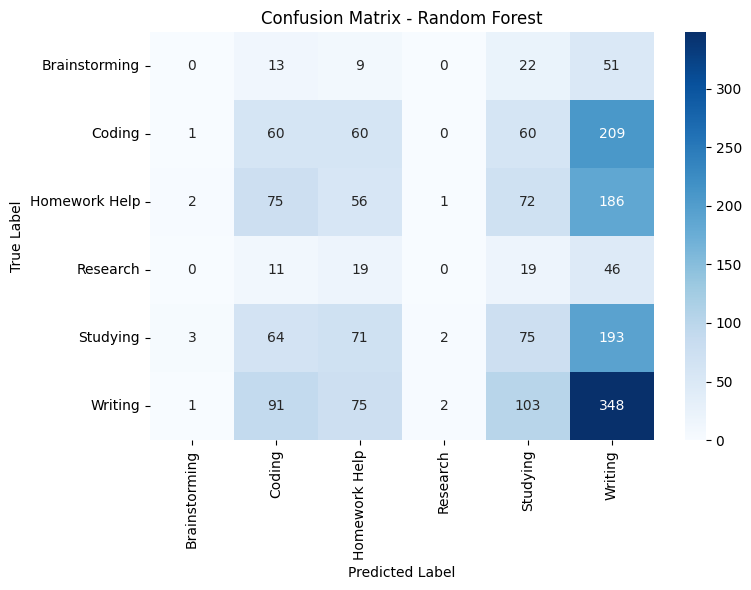


🎯 Feature Importance:
                       feature  importance
0            SessionID_encoded    0.182443
13     SessionLengthMin_scaled    0.177195
9          SessionDate_encoded    0.175185
16   SatisfactionRating_scaled    0.138287
14         TotalPrompts_scaled    0.104371
15   AI_AssistanceLevel_scaled    0.055614
2   StudentLevel_Undergraduate    0.025026
1     StudentLevel_High School    0.018797
5       Discipline_Engineering    0.018161
8        Discipline_Psychology    0.017195


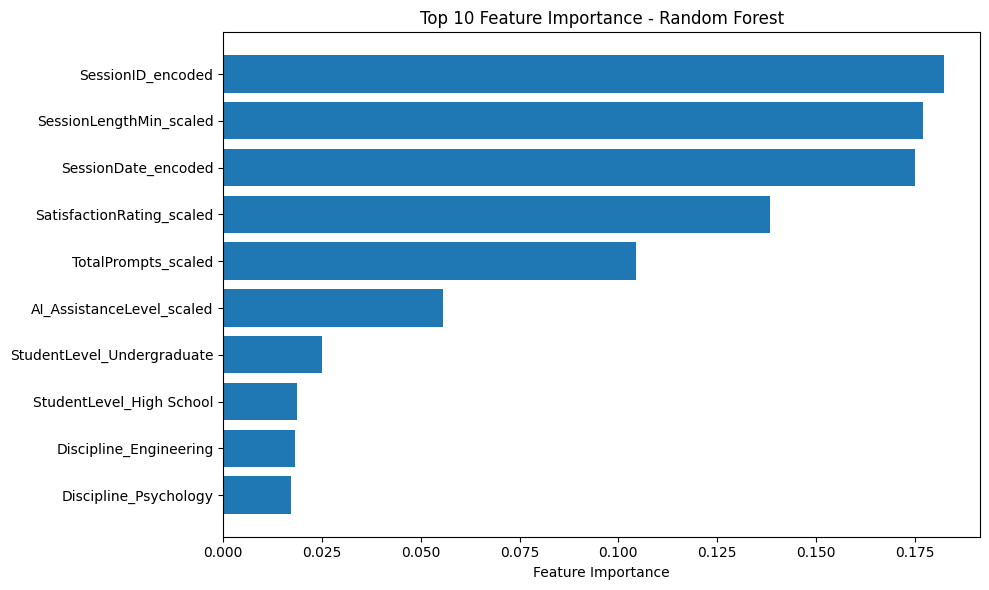

In [ ]:
print("\n" + "="*60)
print(f"🔍 DETAILED ANALYSIS: {best_model_name}")
print("="*60)

best_model = best_model_results['model']
y_pred_best = best_model_results['y_pred']

# Classification Report
print("\n📋 Classification Report:")
report = classification_report(y_test, y_pred_best, target_names=target_classes)
print(report)

# Confusion Matrix
print("\n🔀 Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred_best)
print(cm)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=target_classes, yticklabels=target_classes)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Feature Importance (if available)
if hasattr(best_model, 'feature_importances_'):
    print("\n🎯 Feature Importance:")
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)

    print(feature_importance.head(10))

    # Plot top 10 features
    plt.figure(figsize=(10, 6))
    top_features = feature_importance.head(10)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title(f'Top 10 Feature Importance - {best_model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

elif hasattr(best_model, 'coef_'):
    print("\n🎯 Feature Coefficients:")
    if len(target_classes) == 2:
        feature_coef = pd.DataFrame({
            'feature': X.columns,
            'coefficient': best_model.coef_[0]
        }).sort_values('coefficient', key=abs, ascending=False)
    else:
        # For multiclass, show average absolute coefficients
        feature_coef = pd.DataFrame({
            'feature': X.columns,
            'avg_abs_coefficient': np.mean(np.abs(best_model.coef_), axis=0)
        }).sort_values('avg_abs_coefficient', ascending=False)

    print(feature_coef.head(10))

# **MODEL PERFORMANCE VISUALIZATION**


### 📈 Performance Visualization – Visualisasi Kinerja Model

Tahap ini memvisualisasikan hasil evaluasi model agar lebih mudah dibandingkan.

1. **Model Performance Comparison**

   * Menggunakan *bar chart* untuk membandingkan **Accuracy**, **F1-Score**, **Precision**, dan **Recall** dari semua model yang diuji.
   * Ditampilkan dalam format *subplot* 2x2.

2. **ROC Curves** *(hanya untuk klasifikasi biner)*

   * Menggambar kurva ROC untuk setiap model yang memiliki probabilitas prediksi.
   * Menampilkan *AUC score* pada legenda untuk membandingkan kemampuan model dalam membedakan kelas positif dan negatif.
   * Termasuk garis acuan *Random Classifier* (AUC = 0.5) sebagai pembanding.

Tahap ini memberikan gambaran visual yang cepat dan jelas untuk menentukan model yang paling optimal secara keseluruhan.



In [ ]:
print("\n" + "="*60)
print("📈 PERFORMANCE VISUALIZATION")
print("="*60)

# 1. Model Comparison Chart
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Accuracy', 'F1-Score', 'Precision', 'Recall')
)

models_list = list(model_results.keys())
accuracy_scores = [model_results[m]['accuracy'] for m in models_list]
f1_scores = [model_results[m]['f1_score'] for m in models_list]
precision_scores = [model_results[m]['precision'] for m in models_list]
recall_scores = [model_results[m]['recall'] for m in models_list]

# Add traces
fig.add_trace(go.Bar(x=models_list, y=accuracy_scores, name='Accuracy'), row=1, col=1)
fig.add_trace(go.Bar(x=models_list, y=f1_scores, name='F1-Score'), row=1, col=2)
fig.add_trace(go.Bar(x=models_list, y=precision_scores, name='Precision'), row=2, col=1)
fig.add_trace(go.Bar(x=models_list, y=recall_scores, name='Recall'), row=2, col=2)

fig.update_layout(height=600, title_text="Model Performance Comparison", showlegend=False)
fig.show()

# 2. ROC Curves (for binary classification)
if len(target_classes) == 2:
    plt.figure(figsize=(10, 8))

    for name, results in model_results.items():
        if results['y_pred_proba'] is not None:
            fpr, tpr, _ = roc_curve(y_test, results['y_pred_proba'][:, 1])
            auc_score = results['roc_auc']
            plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves Comparison')
    plt.legend()
    plt.grid(True)
    plt.show()


📈 PERFORMANCE VISUALIZATION


# **HYPERPARAMETER TUNING FOR BEST MODEL**



### 🔧 Hyperparameter Tuning – Penyempurnaan Parameter Model

Tahap ini mengoptimalkan kinerja model terbaik melalui pencarian parameter terbaik menggunakan **GridSearchCV**.

1. **Parameter Grid**

   * Disiapkan *parameter grid* spesifik untuk tiap model (*Random Forest*, *Gradient Boosting*, *Logistic Regression*, *SVM*).
   * Hanya model terbaik yang dilanjutkan untuk tuning.

2. **Proses Grid Search**

   * Menggunakan *cross-validation* (cv=3) untuk menguji kombinasi parameter.
   * Metrik evaluasi utama: **F1-Weighted**.

3. **Evaluasi Hasil Tuning**

   * Menampilkan parameter terbaik dan skor CV terbaik.
   * Menghitung **Accuracy** dan **F1-Score** pada data uji.
   * Jika model hasil tuning memberikan skor lebih baik, model diperbarui.

Tahap ini bertujuan memaksimalkan performa model tanpa mengubah algoritma dasarnya.


In [ ]:
print("\n" + "="*60)
print(f"🔧 HYPERPARAMETER TUNING: {best_model_name}")
print("="*60)

# Define parameter grids
param_grids = {
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5]
    },
    'Gradient Boosting': {
        'n_estimators': [50, 100],
        'learning_rate': [0.1, 0.2],
        'max_depth': [3, 5]
    },
    'Logistic Regression': {
        'C': [0.1, 1.0, 10.0],
        'penalty': ['l2']
    },
    'Support Vector Machine': {
        'C': [0.1, 1.0, 10.0],
        'kernel': ['rbf', 'linear']
    }
}

if best_model_name in param_grids:
    print(f"🔍 Tuning hyperparameters for {best_model_name}...")

    # Create new instance of best model
    if best_model_name == 'Random Forest':
        base_model = RandomForestClassifier(random_state=42)
    elif best_model_name == 'Gradient Boosting':
        base_model = GradientBoostingClassifier(random_state=42)
    elif best_model_name == 'Logistic Regression':
        base_model = LogisticRegression(random_state=42, max_iter=1000)
    elif best_model_name == 'Support Vector Machine':
        base_model = SVC(random_state=42, probability=True)

    # Grid search
    grid_search = GridSearchCV(
        base_model,
        param_grids[best_model_name],
        cv=3,  # Reduced for faster execution
        scoring='f1_weighted',
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)

    # Best parameters
    print(f"✅ Best parameters: {grid_search.best_params_}")
    print(f"📊 Best CV score: {grid_search.best_score_:.4f}")

    # Evaluate tuned model
    y_pred_tuned = grid_search.predict(X_test)
    accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
    f1_tuned = f1_score(y_test, y_pred_tuned, average='weighted')

    print(f"🎯 Tuned model performance:")
    print(f"   Accuracy: {accuracy_tuned:.4f} (vs {best_model_results['accuracy']:.4f})")
    print(f"   F1-Score: {f1_tuned:.4f} (vs {best_model_results['f1_score']:.4f})")

    # Update best model if improved
    if f1_tuned > best_model_results['f1_score']:
        best_model = grid_search.best_estimator_
        print("🚀 Model improved with hyperparameter tuning!")
    else:
        print("📊 Original model performs similarly")


🔧 HYPERPARAMETER TUNING: Random Forest
🔍 Tuning hyperparameters for Random Forest...
✅ Best parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 50}
📊 Best CV score: 0.2588
🎯 Tuned model performance:
   Accuracy: 0.2845 (vs 0.2695)
   F1-Score: 0.2515 (vs 0.2363)
🚀 Model improved with hyperparameter tuning!


# **PREDICTION EXAMPLES**

Bagian **🔮 PREDICTION EXAMPLES** ini fungsinya untuk memberikan contoh nyata hasil prediksi model di data uji, supaya kita bisa secara cepat melihat kinerja model di level individual, bukan hanya angka metrik keseluruhan.


---

### 🔮 Prediction Examples – Contoh Prediksi Model

1. **Pengambilan Sampel**

   * Dipilih maksimal 10 data acak dari `X_test` untuk ditampilkan.

2. **Informasi yang Ditampilkan**

   * **Actual** → label sebenarnya.
   * **Predicted** → label yang diprediksi model.
   * **Confidence** → probabilitas prediksi tertinggi (jika tersedia).
   * **Status** → tanda ✅ jika benar, ❌ jika salah.

3. **Tujuan**

   * Mempermudah interpretasi kinerja model.
   * Melihat contoh di mana model benar dan salah prediksi.
   * Memahami tingkat kepercayaan model pada prediksinya.



In [ ]:
print("\n" + "="*60)
print("🔮 PREDICTION EXAMPLES")
print("="*60)

# Show some prediction examples
n_examples = min(10, len(X_test))
example_indices = np.random.choice(len(X_test), n_examples, replace=False)

print("Sample Predictions:")
print("-" * 50)

for i, idx in enumerate(example_indices):
    actual = target_classes[y_test[idx]]
    predicted = target_classes[y_pred_best[idx]]

    # Check if 'y_pred_proba' exists in best_model_results before accessing
    if 'y_pred_proba' in best_model_results and best_model_results['y_pred_proba'] is not None:
        confidence = np.max(best_model_results['y_pred_proba'][idx])
    else:
        confidence = "N/A"


    status = "✅" if actual == predicted else "❌"
    print(f"{i+1:2d}. {status} Actual: {actual:15} | Predicted: {predicted:15} | Confidence: {confidence}")


🔮 PREDICTION EXAMPLES
Sample Predictions:
--------------------------------------------------
 1. ❌ Actual: Homework Help   | Predicted: Coding          | Confidence: 0.31
 2. ❌ Actual: Coding          | Predicted: Studying        | Confidence: 0.31
 3. ❌ Actual: Homework Help   | Predicted: Writing         | Confidence: 0.39
 4. ❌ Actual: Writing         | Predicted: Homework Help   | Confidence: 0.29
 5. ❌ Actual: Writing         | Predicted: Coding          | Confidence: 0.3
 6. ❌ Actual: Studying        | Predicted: Writing         | Confidence: 0.4
 7. ❌ Actual: Homework Help   | Predicted: Studying        | Confidence: 0.48
 8. ✅ Actual: Writing         | Predicted: Writing         | Confidence: 0.28
 9. ✅ Actual: Homework Help   | Predicted: Homework Help   | Confidence: 0.37
10. ❌ Actual: Coding          | Predicted: Writing         | Confidence: 0.35


# **SUMMARY AND INSIGHTS**

In [ ]:
print("\n" + "="*60)
print("📊 CLASSIFICATION ANALYSIS SUMMARY")
print("="*60)

# Ringkasan dataset & target
summary_data = {
    "🎯 Target Variable": target_col,
    "📏 Dataset Size": f"{len(df):,} samples",
    "🔧 Features Used": X.shape[1],
    "🏷️ Classes": f"{len(target_classes)} ({', '.join(target_classes)})"
}

# Ringkasan model terbaik
model_data = {
    "🏆 Best Model": best_model_name,
    "📊 Accuracy": f"{best_model_results['accuracy']:.4f}",
    "🎯 F1-Score": f"{best_model_results['f1_score']:.4f}",
    "🔄 Cross-Val": f"{best_model_results['cv_mean']:.4f} (±{best_model_results['cv_std']:.4f})"
}

# Cetak ringkasan tabel
df_summary = pd.DataFrame(list(summary_data.items()), columns=["Description", "Value"])
df_model = pd.DataFrame(list(model_data.items()), columns=["Description", "Value"])

print("\n📂 Dataset Info")
display(df_summary)

print("\n🤖 Best Model Info")
display(df_model)

# Key insights
print("\n💡 Key Insights")
insights = [
    f"1. Best performing model: **{best_model_name}**",
    f"2. Model achieves **{best_model_results['accuracy']*100:.1f}%** accuracy"
]

if hasattr(best_model, 'feature_importances_'):
    top_feature = feature_importance.iloc[0]['feature']
    insights.append(f"3. Most important feature: **{top_feature}**")

balance_status = "well-balanced" if best_model_results['precision'] > 0.8 and best_model_results['recall'] > 0.8 else "needs improvement"
insights.append(f"4. Model is **{balance_status}**")

for line in insights:
    print(line)

# Next steps
print("\n🚀 Next Steps")
next_steps = [
    "1. 📝 Proceed to text summarization analysis",
    "2. 🔍 Detailed model evaluation and interpretation",
    "3. 📊 Create comprehensive visualizations"
]
for step in next_steps:
    print(step)

print("\n✅ Classification analysis completed successfully!")



📊 CLASSIFICATION ANALYSIS SUMMARY

📂 Dataset Info


,Description,Value
0,🎯 Target Variable,TaskType
1,📏 Dataset Size,"10,000 samples"
2,🔧 Features Used,17
3,🏷️ Classes,"6 (Brainstorming, Coding, Homework Help, Resea..."



🤖 Best Model Info


,Description,Value
0,🏆 Best Model,Random Forest
1,📊 Accuracy,0.2695
2,🎯 F1-Score,0.2363
3,🔄 Cross-Val,0.2863 (±0.0160)



💡 Key Insights
1. Best performing model: **Random Forest**
2. Model achieves **27.0%** accuracy
3. Most important feature: **SessionID_encoded**
4. Model is **needs improvement**

🚀 Next Steps
1. 📝 Proceed to text summarization analysis
2. 🔍 Detailed model evaluation and interpretation
3. 📊 Create comprehensive visualizations

✅ Classification analysis completed successfully!
